# Тема 2. Когортный анализ

### 2.6 Расчёт Retention Rate в Python. Функция div()

Retention Rate, или коэффициент удержания, показывает, как долго клиенты остаются с компанией. Это один из важнейших показателей «здоровья» бизнеса. 

Чтобы узнать Retention Rate, нужно разделить количество активных пользователей на текущий день на количество активных пользователей на первый день. В когортном анализе расчёт усложняется, потому что операцию нужно провести со всеми когортами.

### Как рассчитать Retention Rate в Python

- Получить журнал сессий и профили пользователей.
- Объединить данные сессий с профилями.
- Рассчитать лайфтайм пользователя для каждой сессии.
- Построить таблицу удержания. То есть сводную таблицу, в которой названия строк — это даты первого посещения пользователей, названия столбцов — лайфтайм, а значения в «ячейках» — количество уникальных идентификаторов пользователей.
- Вычислить размеры когорт и занести результаты в отдельную таблицу.
- Объединить таблицы размеров когорт и удержания.
- Разделить каждую «ячейку» таблицы удержания на соответствующий размер когорты.

Алгоритм может показаться сложным, но на деле это лишь несколько строчек кода. Разберём его на примере данных магазина «Читать не вредно». 


In [1]:
import pandas as pd

# загружаем данные
sessions = pd.read_csv('/datasets/sessions.csv')
profiles = pd.read_csv('/datasets/profiles.csv')

# преобразуем данные о времени для дальнейших расчётов
profiles['first_ts'] = pd.to_datetime(profiles['first_ts'])
profiles['dt'] = pd.to_datetime(profiles['dt']).dt.date
sessions['session_start'] = pd.to_datetime(sessions['session_start'])

display(profiles.head(5)) # профили
sessions.head(5) # журнал сессий

,user_id,first_ts,channel,device,region,dt,month,payer
0,10964006,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01 00:00:00,True
1,12358165,2019-05-10 23:16:24,Yandex,iPhone,United States,2019-05-10,2019-05-01 00:00:00,False
2,12545358,2019-05-05 19:22:46,Organic,Mac,United States,2019-05-05,2019-05-01 00:00:00,False
3,16165560,2019-05-10 20:29:59,Yandex,PC,United States,2019-05-10,2019-05-01 00:00:00,False
4,17733464,2019-05-12 11:08:25,Organic,iPhone,France,2019-05-12,2019-05-01 00:00:00,True


,user_id,region,device,channel,session_duration,session_start
0,94834909438,Germany,iPhone,Yandex,5.417238,2019-05-01 12:59:48
1,142292250445,United States,iPhone,Organic,33.232475,2019-05-01 21:25:00
2,486879489291,United States,Mac,Organic,33.635569,2019-05-01 21:18:40
3,996478278264,Germany,iPhone,Yandex,76.792801,2019-05-01 07:37:52
4,857023407503,United States,Android,Organic,5.976421,2019-05-01 01:35:01



Профили содержат информацию о первых визитах пользователей на сайт, но для расчёта Retention Rate нужны данные обо всех посещениях из журнала сессий.

Чтобы их получить, объединим датафреймы по столбцу `user_id` методом `merge()`. В профилях нет лишь двух столбцов из журнала сессий: `session_start` с временем начала всех сессий и `session_duration` с их длительностью. Последний не пригодится для расчёта удержания, поэтому переносим в профили только `session_start`.


In [2]:
# присоединяем session_start к профилям по столбцу user_id

result_raw = profiles.merge(
    sessions[['user_id', 'session_start']], on='user_id', how='left'
)

result_raw

,user_id,first_ts,channel,device,region,dt,month,payer,session_start
0,10964006,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01 00:00:00,True,2019-05-12 04:50:17
1,10964006,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01 00:00:00,True,2019-05-13 04:00:27
2,10964006,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01 00:00:00,True,2019-05-14 04:21:06
3,12358165,2019-05-10 23:16:24,Yandex,iPhone,United States,2019-05-10,2019-05-01 00:00:00,False,2019-05-10 23:16:24
4,12358165,2019-05-10 23:16:24,Yandex,iPhone,United States,2019-05-10,2019-05-01 00:00:00,False,2019-05-11 11:01:14
...,...,...,...,...,...,...,...,...,...
282932,999954663782,2019-05-04 09:57:28,AnotherSource,Android,United States,2019-05-04,2019-05-01 00:00:00,False,2019-05-04 09:57:28
282933,999957797889,2019-05-14 21:54:26,Yandex,Android,Russian Federation,2019-05-14,2019-05-01 00:00:00,False,2019-05-14 21:54:26
282934,999974288578,2019-05-07 03:42:53,Organic,iPhone,France,2019-05-07,2019-05-01 00:00:00,False,2019-05-07 03:42:53
282935,999996691258,2019-05-05 09:27:58,AnotherSource,iPhone,Russian Federation,2019-05-05,2019-05-01 00:00:00,False,2019-05-05 09:27:58


In [3]:
# вычисляем лайфтайм для каждой сессии в днях

result_raw['lifetime'] = (
    result_raw['session_start'] - result_raw['first_ts']
).dt.days

result_raw.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,session_start,lifetime
0,10964006,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01 00:00:00,True,2019-05-12 04:50:17,0
1,10964006,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01 00:00:00,True,2019-05-13 04:00:27,0
2,10964006,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01 00:00:00,True,2019-05-14 04:21:06,1
3,12358165,2019-05-10 23:16:24,Yandex,iPhone,United States,2019-05-10,2019-05-01 00:00:00,False,2019-05-10 23:16:24,0
4,12358165,2019-05-10 23:16:24,Yandex,iPhone,United States,2019-05-10,2019-05-01 00:00:00,False,2019-05-11 11:01:14,0


Далее по плану — таблица удержания. Её ещё называют треугольной таблицей. 

Применим метод `pivot_table()`. Чтобы сделать даты первого посещения заголовками строк, лайфтаймы — заголовками столбцов, а количество уникальных пользователей — значениями, передадим параметру `index` значения столбца `dt`, параметру `columns` — значения `lifetime`, параметру `values` — значения `user_id`, а параметру `aggfunc` — функцию для подсчёта уникальных значений `nunique`. 


In [4]:
# строим таблицу удержания

result_grouped = result_raw.pivot_table(
    index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
)

result_grouped

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13
dt,,,,,,,,,,,,,,
2019-05-01,10369.0,4213.0,3059.0,2415.0,1993.0,1750.0,1473.0,1418.0,1250.0,1107.0,1013.0,917.0,869.0,404.0
2019-05-02,8556.0,3410.0,2575.0,1986.0,1730.0,1430.0,1207.0,1084.0,992.0,862.0,857.0,803.0,402.0,NaN
2019-05-03,9029.0,1715.0,924.0,551.0,369.0,285.0,238.0,185.0,144.0,123.0,118.0,35.0,NaN,NaN
2019-05-04,11426.0,2143.0,1200.0,694.0,470.0,339.0,275.0,233.0,199.0,160.0,65.0,NaN,NaN,NaN
2019-05-05,11155.0,1502.0,622.0,378.0,222.0,145.0,129.0,76.0,64.0,37.0,NaN,NaN,NaN,NaN
2019-05-06,11554.0,2839.0,1584.0,1114.0,796.0,661.0,503.0,407.0,187.0,NaN,NaN,NaN,NaN,NaN
2019-05-07,9804.0,2343.0,1429.0,935.0,707.0,529.0,404.0,208.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-08,8741.0,2558.0,1654.0,1160.0,909.0,690.0,312.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-09,8973.0,3253.0,2406.0,1781.0,1473.0,675.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Следующий шаг — вычислить размеры когорт. Сгруппируем данные по дате первого посещения из `dt` и посчитаем количество уникальных пользователей в каждой когорте, применив функцию `nunique` к столбцу `user_id`. Столбец с результатами переименуем в соответствии с содержанием в `cohort_size` — размер когорты.


In [5]:
# вычисляем размеры когорт

cohort_sizes = (
    result_raw.groupby('dt')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

cohort_sizes

,cohort_size
dt,
2019-05-01,10369
2019-05-02,8556
2019-05-03,9029
2019-05-04,11426
2019-05-05,11155
2019-05-06,11554
2019-05-07,9804
2019-05-08,8741
2019-05-09,8973


Финишная прямая. Объединим таблицу размеров когорт с таблицей удержания по столбцу `dt` методом `merge()`. Отсутствующие значения `NaN` заменим на `0` методом `fillna()`.

In [6]:
# объединяем размеры когорт и таблицу удержания

result_grouped = cohort_sizes.merge(
    result_grouped, on='dt', how='left'
).fillna(0)

result_grouped

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
dt,,,,,,,,,,,,,,,
2019-05-01,10369,10369.0,4213.0,3059.0,2415.0,1993.0,1750.0,1473.0,1418.0,1250.0,1107.0,1013.0,917.0,869.0,404.0
2019-05-02,8556,8556.0,3410.0,2575.0,1986.0,1730.0,1430.0,1207.0,1084.0,992.0,862.0,857.0,803.0,402.0,0.0
2019-05-03,9029,9029.0,1715.0,924.0,551.0,369.0,285.0,238.0,185.0,144.0,123.0,118.0,35.0,0.0,0.0
2019-05-04,11426,11426.0,2143.0,1200.0,694.0,470.0,339.0,275.0,233.0,199.0,160.0,65.0,0.0,0.0,0.0
2019-05-05,11155,11155.0,1502.0,622.0,378.0,222.0,145.0,129.0,76.0,64.0,37.0,0.0,0.0,0.0,0.0
2019-05-06,11554,11554.0,2839.0,1584.0,1114.0,796.0,661.0,503.0,407.0,187.0,0.0,0.0,0.0,0.0,0.0
2019-05-07,9804,9804.0,2343.0,1429.0,935.0,707.0,529.0,404.0,208.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-08,8741,8741.0,2558.0,1654.0,1160.0,909.0,690.0,312.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-09,8973,8973.0,3253.0,2406.0,1781.0,1473.0,675.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Наконец, рассчитаем коэффициенты удержания. Для этого вызовем функцию `div()`, выполняющую деление. Передадим ей столбец `cohort_size` в качестве делителя и параметр `axis`, равный нулю.

### **Как работает параметр `axis` в `div()`**

```
           angles  degrees
circle          0      360
triangle        3      180
rectangle       4      360
```

Возьмём датафрейм `df` с описанием геометрических фигур и передадим функции `div()` делитель `[1, 2, 3]` с `axis=0`.

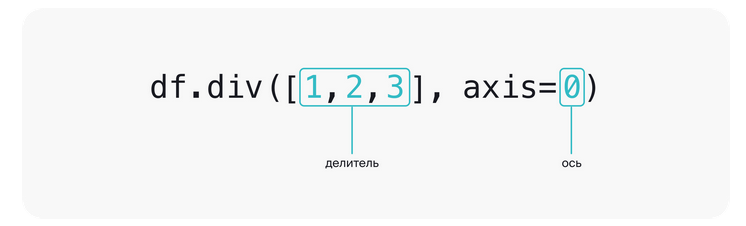

Когда параметр `axis` равен нулю, деление выполняется построчно, или горизонтально: индексы делителя соотносятся с индексами строк. Индекс значения `1` в делителе — `0`, поэтому значения строки с индексом `0` — это `0` и `360` из строки `circle` — делятся на `1`. Индекс значения `2` из делителя соответствует строке `triangle`, а индекс значения `3` — строке `rectangle`, поэтому `3` и `180` делятся на `2`, а `4` и `360` — на `3`.

```
             angles  degrees
circle     0.000000    360.0
triangle   1.500000     90.0
rectangle  1.333333    120.0
```

Если параметр `axis` равен `1`, деление выполняется вертикально: индексы делителя соотносятся с нумерацией столбцов. Столбец `angles` соответствует индексу `0`, поэтому все значения `angles` делятся на `1`, столбец `degrees` — индексу `1`, значит, все значения `degrees` делятся на `2`. 

Важно, чтобы количество значений в делимом и делителе совпадало. Значению `3` из делителя не соответствует по индексу ни одна колонка, поэтому тот же код с `axis=1` выдаст ошибку.

```
ValueError: Unable to coerce to Series, length must be 3: given 2
```

---

В датафрейме `result_grouped` функция `div()` с параметром `axis=0` разделит все значения в каждой строке на соответствующие значения из столбца `cohort_size`. Иначе говоря, разделит все столбцы на столбец `cohort_size`. Результат — доля пользователей, «доживших» до каждого лайфтайма.

Столбец `cohort_size` пока не понадобится — удалим его методом `drop()`.



In [7]:
# делим данные таблицы удержания на размеры когорт

result_grouped = result_grouped.div(
    result_grouped['cohort_size'], axis=0
).drop(columns=['cohort_size'])

result_grouped

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
dt,,,,,,,,,,,,,,
2019-05-01,1.0,0.406307,0.295014,0.232906,0.192208,0.168772,0.142058,0.136754,0.120552,0.106761,0.097695,0.088437,0.083808,0.038962
2019-05-02,1.0,0.398551,0.300958,0.232118,0.202197,0.167134,0.141071,0.126695,0.115942,0.100748,0.100164,0.093852,0.046985,0.000000
2019-05-03,1.0,0.189944,0.102337,0.061026,0.040868,0.031565,0.026360,0.020490,0.015949,0.013623,0.013069,0.003876,0.000000,0.000000
2019-05-04,1.0,0.187555,0.105024,0.060739,0.041134,0.029669,0.024068,0.020392,0.017416,0.014003,0.005689,0.000000,0.000000,0.000000
2019-05-05,1.0,0.134648,0.055760,0.033886,0.019901,0.012999,0.011564,0.006813,0.005737,0.003317,0.000000,0.000000,0.000000,0.000000
2019-05-06,1.0,0.245716,0.137095,0.096417,0.068894,0.057210,0.043535,0.035226,0.016185,0.000000,0.000000,0.000000,0.000000,0.000000
2019-05-07,1.0,0.238984,0.145757,0.095369,0.072113,0.053958,0.041208,0.021216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-05-08,1.0,0.292644,0.189223,0.132708,0.103993,0.078938,0.035694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-05-09,1.0,0.362532,0.268138,0.198484,0.164159,0.075226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Retention Rate пользователей, пришедших в первые две недели мая, посчитан.

Код программы целиком:

In [8]:
import pandas as pd

# загружаем данные
sessions = pd.read_csv('/datasets/sessions.csv') # журнал сессий
profiles = pd.read_csv('/datasets/profiles.csv') # профили пользователей

# преобразуем данные о времени для дальнейших расчётов
profiles['first_ts'] = pd.to_datetime(profiles['first_ts'])
profiles['dt'] = pd.to_datetime(profiles['dt']).dt.date
sessions['session_start'] = pd.to_datetime(sessions['session_start'])

# присоединяем session_start к профилям по столбцу user_id
result_raw = profiles.merge(
    sessions[['user_id', 'session_start']], on='user_id', how='left'
)

# вычисляем лайфтайм каждой сессии в днях
result_raw['lifetime'] = (
    result_raw['session_start'] - result_raw['first_ts']
).dt.days

# строим таблицу удержания
result_grouped = result_raw.pivot_table(
    index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
)

# вычисляем размеры когорт
cohort_sizes = (
    result_raw.groupby('dt')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

# объединяем размеры когорт и таблицу удержания
result_grouped = cohort_sizes.merge(
    result_grouped, on='dt', how='left'
).fillna(0)

# делим данные таблицы удержания на размеры когорт
result_grouped = result_grouped.div(
    result_grouped['cohort_size'], axis=0
).drop(columns=['cohort_size'])

result_grouped

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
dt,,,,,,,,,,,,,,
2019-05-01,1.0,0.406307,0.295014,0.232906,0.192208,0.168772,0.142058,0.136754,0.120552,0.106761,0.097695,0.088437,0.083808,0.038962
2019-05-02,1.0,0.398551,0.300958,0.232118,0.202197,0.167134,0.141071,0.126695,0.115942,0.100748,0.100164,0.093852,0.046985,0.000000
2019-05-03,1.0,0.189944,0.102337,0.061026,0.040868,0.031565,0.026360,0.020490,0.015949,0.013623,0.013069,0.003876,0.000000,0.000000
2019-05-04,1.0,0.187555,0.105024,0.060739,0.041134,0.029669,0.024068,0.020392,0.017416,0.014003,0.005689,0.000000,0.000000,0.000000
2019-05-05,1.0,0.134648,0.055760,0.033886,0.019901,0.012999,0.011564,0.006813,0.005737,0.003317,0.000000,0.000000,0.000000,0.000000
2019-05-06,1.0,0.245716,0.137095,0.096417,0.068894,0.057210,0.043535,0.035226,0.016185,0.000000,0.000000,0.000000,0.000000,0.000000
2019-05-07,1.0,0.238984,0.145757,0.095369,0.072113,0.053958,0.041208,0.021216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-05-08,1.0,0.292644,0.189223,0.132708,0.103993,0.078938,0.035694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-05-09,1.0,0.362532,0.268138,0.198484,0.164159,0.075226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Момент и горизонт анализа данных

В прошлом уроке вы познакомились с понятиями момент и горизонт анализа данных.

- Момент анализа данных — это момент времени, в который вы работаете с данными. Обычно это определённый день.
- Горизонт анализа данных — максимальный лайфтайм, который вы хотите включить в анализ. Если нужно проанализировать удержание пользователей за первые три недели августа, то горизонт анализа составит 21 день: с нулевого по 20-й лайфтайм.

Предположим, аналитик магазина «Читать не вредно» смотрит на данные журнала сессий и пользовательских профилей 14 мая. Задача — проанализировать удержание новых пользователей за 6 дней: с нулевого по пятый лайфтайм.

Добавим в код учёт момента и горизонта анализа данных. 

##### Что для этого нужно

- Задать момент и горизонт анализа.
- Определить, игнорировать ли горизонт.
- Рассчитать максимально возможную дату привлечения пользователей.
- Исключить из анализа пользователей, пришедших после этой даты.
- Исключить из результата все лайфтаймы, превышающие горизонт анализа.

После загрузки и преобразования данных определим момент и горизонт анализа. 

Импортируем функции для работы со временем из библиотеки `datetime`. Горизонт анализа — это количество дней, поэтому его можно задать целым значением. С моментом анализа сложнее, ведь это определённая дата.

Чтобы получить момент анализа, вызовем функцию `datetime()`. Она принимает год, номер месяца и число, а возвращает значение в формате “YYYY-MM-DD 00:00:00”. Если вызвать метод `date()` к результату, получим только дату без времени. Момент анализа сохраним в переменной `observation_date`, а горизонт — в `horizon_days`.

В переменной `ignore_horizon` сохраним информацию об игнорировании горизонта: `True`, если нужно игнорировать, и `False`, если нет.

In [9]:
# импортируем функции для работы со временем
from datetime import datetime, timedelta

# задаём момент и горизонт анализа данных
observation_date = datetime(2019, 5, 14).date()
horizon_days = 6

# создаём опцию «игнорировать горизонт»
ignore_horizon = False

Вычислим максимально возможную дату привлечения пользователей. Она рассчитывается по формуле: `момент анализа данных - горизонт анализа данных`. Вызовем функцию `timedelta()`, чтобы получить временной промежуток, равный максимальному лайфтайму горизонта анализа, и вычтем его из `observation_date`. 

Это и есть максимальная дата привлечения, сохраним её в переменной `last_suitable_acquisition_date`. Теперь можно исключить пользователей, не успевших «прожить» достаточно дней. Сделаем срез профилей методом `query()`: отберём все записи, в которых дата первого посещения из столбца `dt` меньше максимальной.

In [10]:
# рассчитываем максимально возможную дату привлечения
last_suitable_acquisition_date = observation_date
if not ignore_horizon:
    last_suitable_acquisition_date = observation_date - timedelta(
        days=horizon_days - 1
    )

# исключаем пользователей, пришедших после максимальной даты привлечения
result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

result_raw

,user_id,first_ts,channel,device,region,dt,month,payer
2,12545358,2019-05-05 19:22:46,Organic,Mac,United States,2019-05-05,2019-05-01 00:00:00,False
7,47343201,2019-05-07 16:55:48,Organic,iPhone,United States,2019-05-07,2019-05-01 00:00:00,False
9,51602715,2019-05-03 14:57:36,Organic,iPhone,Russian Federation,2019-05-03,2019-05-01 00:00:00,False
10,58494719,2019-05-04 08:31:04,Yandex,iPhone,Germany,2019-05-04,2019-05-01 00:00:00,False
11,59432616,2019-05-03 07:06:42,Organic,iPhone,Germany,2019-05-03,2019-05-01 00:00:00,True
...,...,...,...,...,...,...,...,...
141413,999929830296,2019-05-02 07:55:32,Organic,iPhone,Russian Federation,2019-05-02,2019-05-01 00:00:00,True
141414,999939571625,2019-05-08 17:47:00,Yandex,iPhone,Germany,2019-05-08,2019-05-01 00:00:00,False
141415,999954663782,2019-05-04 09:57:28,AnotherSource,Android,United States,2019-05-04,2019-05-01 00:00:00,False
141417,999974288578,2019-05-07 03:42:53,Organic,iPhone,France,2019-05-07,2019-05-01 00:00:00,False


Затем рассчитываем коэффициент удержания обычным способом. 

Последний шаг: горизонт анализа составляет 6 дней, поэтому выводить данные за все 14 дней не нужно. Удалим из результата все лайфтаймы, превышающие горизонт анализа.

In [11]:
# рассчитываем коэффициент удержания

result_raw = result_raw.merge(
    sessions[['user_id', 'session_start']], on='user_id', how='left'
)  # объединяем профили и журнал сессий

result_raw['lifetime'] = (
    result_raw['session_start'] - result_raw['first_ts']
).dt.days  # вычисляем лайфтайм каждой сессии в днях

result_grouped = result_raw.pivot_table(
    index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
)  # строим таблицу удержания

cohort_sizes = (
    result_raw.groupby('dt')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)  # вычисляем размеры когорт

result_grouped = cohort_sizes.merge(
    result_grouped, on='dt', how='left'
).fillna(0)  # объединяем размеры когорт и таблицу удержания

# делим данные таблицы удержания на размеры когорт
result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

# исключаем из результата все лайфтаймы, превышающие горизонт анализа
result_grouped = result_grouped[['cohort_size'] + list(range(horizon_days))]

# во время деления все значения cohort_size превратились в единицу
# восстанавливаем — они понадобятся нам позже
result_grouped['cohort_size'] = cohort_sizes

result_grouped

,cohort_size,0,1,2,3,4,5
dt,,,,,,,
2019-05-01,10369,1.0,0.406307,0.295014,0.232906,0.192208,0.168772
2019-05-02,8556,1.0,0.398551,0.300958,0.232118,0.202197,0.167134
2019-05-03,9029,1.0,0.189944,0.102337,0.061026,0.040868,0.031565
2019-05-04,11426,1.0,0.187555,0.105024,0.060739,0.041134,0.029669
2019-05-05,11155,1.0,0.134648,0.055760,0.033886,0.019901,0.012999
2019-05-06,11554,1.0,0.245716,0.137095,0.096417,0.068894,0.057210
2019-05-07,9804,1.0,0.238984,0.145757,0.095369,0.072113,0.053958
2019-05-08,8741,1.0,0.292644,0.189223,0.132708,0.103993,0.078938
2019-05-09,8973,1.0,0.362532,0.268138,0.198484,0.164159,0.075226


Вместо треугольной таблицы удержания — прямоугольная. Все пользователи в ней имели шанс «дожить» до шестого дня.

#### Пиши, сокращай

Когда код разрастается, его полезно «упаковывать» в функции. Так программу будет проще использовать и адаптировать для других задач.

Напишем функцию для расчёта коэффициента удержания `get_retention()`. 

Её аргументы: 

- `profiles` — профили пользователей,
- `sessions` — данные журнала сессий,
- `observation_date` — момент анализа,
- `horizon_days` — горизонт анализа в днях,
- `ignore_horizon` — опция «игнорировать горизонт анализа», по умолчанию `False`.

In [12]:
def get_retention(
    profiles, sessions, observation_date, horizon_days, ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby('dt')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on='dt', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return result_raw, result_grouped

Теперь для расчёта коэффициента удержания достаточно вызвать `get_retention()`. Вычислим Retention Rate с учётом нового момента анализа данных — 13 мая 2019 года. Горизонт анализа по-прежнему составляет 6 дней.


In [13]:
retention_raw, retention = get_retention(
    profiles, sessions, datetime(2019, 5, 13).date(), 6
)

retention

,cohort_size,0,1,2,3,4,5
dt,,,,,,,
2019-05-01,10369,1.0,0.406307,0.295014,0.232906,0.192208,0.168772
2019-05-02,8556,1.0,0.398551,0.300958,0.232118,0.202197,0.167134
2019-05-03,9029,1.0,0.189944,0.102337,0.061026,0.040868,0.031565
2019-05-04,11426,1.0,0.187555,0.105024,0.060739,0.041134,0.029669
2019-05-05,11155,1.0,0.134648,0.055760,0.033886,0.019901,0.012999
2019-05-06,11554,1.0,0.245716,0.137095,0.096417,0.068894,0.057210
2019-05-07,9804,1.0,0.238984,0.145757,0.095369,0.072113,0.053958
2019-05-08,8741,1.0,0.292644,0.189223,0.132708,0.103993,0.078938


В отличие от таблицы удержания с моментом анализа 14 мая, здесь отсутствуют данные за 9 мая, так как пришедшие в этот день пользователи не успели бы набрать достаточное количество дней.

Ради эксперимента проигнорируем горизонт анализа данных, установив `ignore_horizon=True`.

In [14]:
retention_raw, retention = get_retention(
    profiles, sessions, datetime(2019, 5, 13).date(), 6, ignore_horizon=True
)

retention

,cohort_size,0,1,2,3,4,5
dt,,,,,,,
2019-05-01,10369,1.0,0.406307,0.295014,0.232906,0.192208,0.168772
2019-05-02,8556,1.0,0.398551,0.300958,0.232118,0.202197,0.167134
2019-05-03,9029,1.0,0.189944,0.102337,0.061026,0.040868,0.031565
2019-05-04,11426,1.0,0.187555,0.105024,0.060739,0.041134,0.029669
2019-05-05,11155,1.0,0.134648,0.055760,0.033886,0.019901,0.012999
2019-05-06,11554,1.0,0.245716,0.137095,0.096417,0.068894,0.057210
2019-05-07,9804,1.0,0.238984,0.145757,0.095369,0.072113,0.053958
2019-05-08,8741,1.0,0.292644,0.189223,0.132708,0.103993,0.078938
2019-05-09,8973,1.0,0.362532,0.268138,0.198484,0.164159,0.075226


Без учёта горизонта анализа результат включает всех пользователей, даже тех, кто не успел «прожить» необходимые шесть дней.